# Introduction

The NBA-games dataset is a really great dataset with lots of information about  teams and results that can be put together in order to create a predictive model for future games. This notebook offers an elo-based approach to NBA games prediction.
The Idea is to associate a number to the level of a team (the higher the better the level of the team) and then to calculate the win probability of a team during a certain match based on the ELO difference of the two teams.


## Step 1 :  Importing of important Libraries and creation of important dataframes.


In [49]:
import numpy as np
import pandas as pd
import re
import warnings

import seaborn as sn
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from sklearn.metrics import accuracy_score
from adjustText import adjust_text
from textwrap import wrap

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)

games = pd.read_csv('games.csv')
details = pd.read_csv('games_details.csv')
teams = pd.read_csv('teams.csv')
ranking = pd.read_csv('ranking.csv')

details['PLAYER_NAME_SHORT'] = details['PLAYER_NAME'].str.replace('^(.).*\s(.*)', '\\1.\\2')
details[["MINS", "SECS"]] = details.MIN.str.extract(r"([^:]+):(.*)")
details.loc[(~details.MIN.str.contains(':', na = True)), 'SECS'] = details.MIN
details.MINS = pd.to_numeric(details.MINS)
details.SECS = pd.to_numeric(details.SECS)
details['PLAY_TIME'] = np.round(details.MINS.fillna(0) + details.SECS/60)

games = games.loc[~games[['GAME_ID', 'GAME_DATE_EST']].duplicated()] #Leaving one entry per game
games['GAME_DATE_EST'] = pd.to_datetime(games.GAME_DATE_EST)


# Step 2 : preparing the predictive modelling dataset

As always, the crucial task when given NBA stats is to manage to predict the outcome of future games based on the already available stats. But while we could use the datasets as they are, it is much better to try to create new meaningful features to help with prediction accuracy.

# What are the modifications applied to each dataframe ?  

* ranking dataframe : the date format has been change, the dataframe has been sorted by date, the season_id has been changed, a column 'MAX_S_GAMES' has been added which contains the maximum games, played in each seasons
* a 'start dates' dataframe has been created, it contains the start dates of each NBA season
* a 'playoffs dates' dataframe has been created it contains the date of the last game of the playoffs
* a 'dates' dataframe has been created it merged the two previous dataframes. It allows us to know when started and ended each NBA seasons.
* the 'details' dataframe has removed each informations about non-regular season games
* a 'ranking short' dataframe has been created it contains fewer columns than the ranking one and is in datre order
* a 'games short' dataframe has been created it has been created by merging the date dataframe and the games dataframe






In [50]:
ranking['STANDINGSDATE'] = pd.to_datetime(ranking['STANDINGSDATE'])
ranking.sort_values('STANDINGSDATE', inplace = True)
ranking = ranking.loc[ranking.SEASON_ID // 10000 == 2]
ranking['SEASON_ID'] = ranking['SEASON_ID'] % 10000
ranking['MAX_S_GAMES'] = ranking.groupby('SEASON_ID').G.transform(max)

# Creating a df with season start and end for excluding preseason and playoff games
start_dates = ranking.loc[ranking.SEASON_ID > 2002].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('FIRST_GAME').reset_index()
t = ranking.loc[(ranking.G == ranking.MAX_S_GAMES)].groupby(['SEASON_ID', 'STANDINGSDATE'])['TEAM_ID'].nunique().to_frame('TEAMS').reset_index()
playoff_dates = t.loc[(t.TEAMS == 30) | 
                      ((t.TEAMS == 28) & (t.SEASON_ID == 2012)) | 
                      ((t.TEAMS == 29) & (t.SEASON_ID == 2003))].groupby('SEASON_ID')['STANDINGSDATE'].min().to_frame('LAST_GAME').reset_index()
dates = start_dates.merge(playoff_dates, how = 'left')
dates.loc[dates.SEASON_ID == 2019, 'LAST_GAME'] = pd.to_datetime('2020-03-12') #Manually adding the end of regular season

# Filtering out details for non-regular season games
details = details.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON']], how = 'left')
details = details.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'left')
details = details.loc[(details.LAST_GAME.isnull()) | ((details.GAME_DATE_EST <= details.LAST_GAME) & (details.GAME_DATE_EST > details.FIRST_GAME))]

# Filtering out games for non-regular season games
games = games.merge(dates, left_on = 'SEASON', right_on = 'SEASON_ID', how = 'inner')
games = games.loc[games.LAST_GAME.isnull() | ((games.GAME_DATE_EST <= games.LAST_GAME) & (games.GAME_DATE_EST > games.FIRST_GAME))]
games.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace=True)

# Excluding the 2020 season as it was plagued by Covid related results
details = details.loc[details.SEASON != 2020]
games = games.loc[games.SEASON != 2020]
dates = dates.loc[dates.SEASON_ID != 2020]

# Creating a new ranking df with regular season only and values that can be used for modeling 
ranking_short = ranking[['TEAM_ID', 'SEASON_ID', 'STANDINGSDATE', 'CONFERENCE', 'TEAM', 'G', 'W', 'L', 'HOME_RECORD', 'ROAD_RECORD']].merge(dates)
ranking_short = ranking_short.loc[(ranking_short.STANDINGSDATE >= ranking_short.FIRST_GAME) & (ranking_short.STANDINGSDATE <= ranking_short.LAST_GAME)]
ranking_short = ranking_short.loc[ranking_short.G > 0]
ranking_short[['HOME_W', 'HOME_L']] = ranking_short.HOME_RECORD.str.split('-', expand = True)
ranking_short[['AWAY_W', 'AWAY_L']] = ranking_short.ROAD_RECORD.str.split('-', expand = True)
ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = ranking_short[['HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']].apply(pd.to_numeric)
ranking_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME', 'HOME_RECORD', 'ROAD_RECORD'], inplace = True)
ranking_short.sort_values('STANDINGSDATE', inplace = True)

# Creating a new games df with regular season only
games_short = pd.merge(games[['GAME_ID', 'GAME_DATE_EST', 'SEASON', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'HOME_TEAM_WINS']], dates, left_on = 'SEASON', right_on = 'SEASON_ID')
games_short = games_short.loc[(games_short.GAME_DATE_EST > games_short.FIRST_GAME) & (games_short.GAME_DATE_EST <= games_short.LAST_GAME)]
games_short.drop(columns = ['SEASON_ID', 'FIRST_GAME', 'LAST_GAME'], inplace = True)
games_short.sort_values('GAME_DATE_EST', inplace = True)

## Step 3 : calculating ELO for each team

The [ELO statistic](https://en.wikipedia.org/wiki/Elo_rating_system) was originally divised by Arpad Elo for ranking players in chess games. In order to adjust the calculation for NBA games, the methodology was adjusted by [538](https://fivethirtyeight.com/).  
The main points of the calculation:
* Winning a game increases the ELO of the team and losing a game decreases it
* The amount of increase/decrease depends on a) the margin of victory b) the pre-game expectations for the outcome of the game (which are based on the ELO rating of the two teams)
* Ratings are adjusted after each game 
* After each season each team'elo is equal to 75% of the previous year elo + 25% of 1500 which is the average Elo.

This notebook consider all teams to start from the same ELO in 2003 and loops through each games played by them since then and upgrades the winner's elo and decreases the loser's one without forgetting the season 'refresh'.


In [51]:
def mov_mult(mov, elo_diff):
    return (mov + 3)**0.8/(7.5 + 0.006*(elo_diff))

def win_prob(elo_diff):
    return 1/(10**(-elo_diff/400) + 1)

def update_elo(team_elo, game_data, k=20):
    if game_data.MOV < 0:        
        mult = mov_mult(-game_data.MOV, -game_data.ELO_DIFF)
        elo_change =  k*(game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] -= elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] += elo_change
    else:
        mult = mov_mult(game_data.MOV, game_data.ELO_DIFF)
        elo_change =  k*(1-game_data.HOME_WIN_PR)*mult
        team_elo.loc[team_elo.TEAM == game_data.HOME_TEAM_ID, 'ELO'] += elo_change
        team_elo.loc[team_elo.TEAM == game_data.VISITOR_TEAM_ID, 'ELO'] -= elo_change
        
elo_data = games[['GAME_DATE_EST', 'GAME_ID', 'HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'SEASON', 'PTS_home', 'PTS_away']].copy()
elo_data['MOV'] = elo_data['PTS_home'] - elo_data['PTS_away']
elo_data.sort_values('GAME_DATE_EST', inplace=True)
elo_data = elo_data.dropna()
elo_data[['HOME_ELO', 'VISITOR_ELO', 'ELO_DIFF', 'HOME_WIN_PR', 'VISITOR_WIN_PR']] = 0
elo_data.reset_index(inplace=True, drop=True)


teams_dict = dict(zip(teams.TEAM_ID, teams.ABBREVIATION))
team_elo = pd.DataFrame({'TEAM':pd.unique(elo_data[['HOME_TEAM_ID', 'VISITOR_TEAM_ID']].values.ravel('K')), 
                         'ELO':1500})
team_elo['NAME'] = team_elo.TEAM.map(teams_dict)
team_elo_l = []

current_season = 2003
home_elo_col = elo_data.columns.get_loc("HOME_ELO")
visitor_elo_col = elo_data.columns.get_loc("VISITOR_ELO")
home_team_col = elo_data.columns.get_loc('HOME_TEAM_ID')
visitor_team_col = elo_data.columns.get_loc('VISITOR_TEAM_ID')
elo_diff_col = elo_data.columns.get_loc('ELO_DIFF')
home_win_col = elo_data.columns.get_loc('HOME_WIN_PR')
visitor_win_col = elo_data.columns.get_loc('VISITOR_WIN_PR')

for i in range(len(elo_data)):
    if elo_data.iloc[i, elo_data.columns.get_loc('SEASON')] != current_season:
        team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))
        team_elo['ELO'] = 0.75*team_elo.ELO + 0.25*1500 # Reverting back to the mean for the start of each season
        current_season = elo_data.iloc[i, elo_data.columns.get_loc('SEASON')]
        
    elo_data.iloc[i, home_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, home_team_col], 'ELO'].values + 100
    elo_data.iloc[i, visitor_elo_col] = team_elo.loc[team_elo.TEAM == elo_data.iloc[i, visitor_team_col], 'ELO'].values
    elo_data.iloc[i, elo_diff_col] = elo_data.iloc[i, home_elo_col] - elo_data.iloc[i, visitor_elo_col]
    elo_data.iloc[i, home_win_col] = win_prob(elo_data.iloc[i, elo_diff_col])
    elo_data.iloc[i, visitor_win_col] = 1-elo_data.iloc[i, home_win_col]
    update_elo(team_elo, elo_data.iloc[i])
team_elo_l.append(team_elo.sort_values(by = 'ELO', ascending = False).head(5).assign(SEASON = current_season))

## Preparing chart data

team_nick_dict = dict(zip(teams.TEAM_ID, teams.NICKNAME)) 
elo_plot_df = pd.concat(team_elo_l)
elo_plot_df['NICKNAME'] = elo_plot_df.TEAM.map(team_nick_dict)
top_teams = elo_plot_df.groupby('NAME').size().nlargest(4, keep='all').index.tolist()
all_teams = elo_plot_df.NAME.unique()
colors = len(all_teams)
color_dict = {}

#cm = plt.get_cmap('gist_rainbow')
cm = plt.get_cmap('Accent')
color_counter = 0
for i in range(colors):
    if all_teams[i] in top_teams:
        color_dict[all_teams[i]] = np.array(cm(1.*color_counter/len(top_teams)))
        color_counter += 1
    else:
        color_dict[all_teams[i]] = 'white'


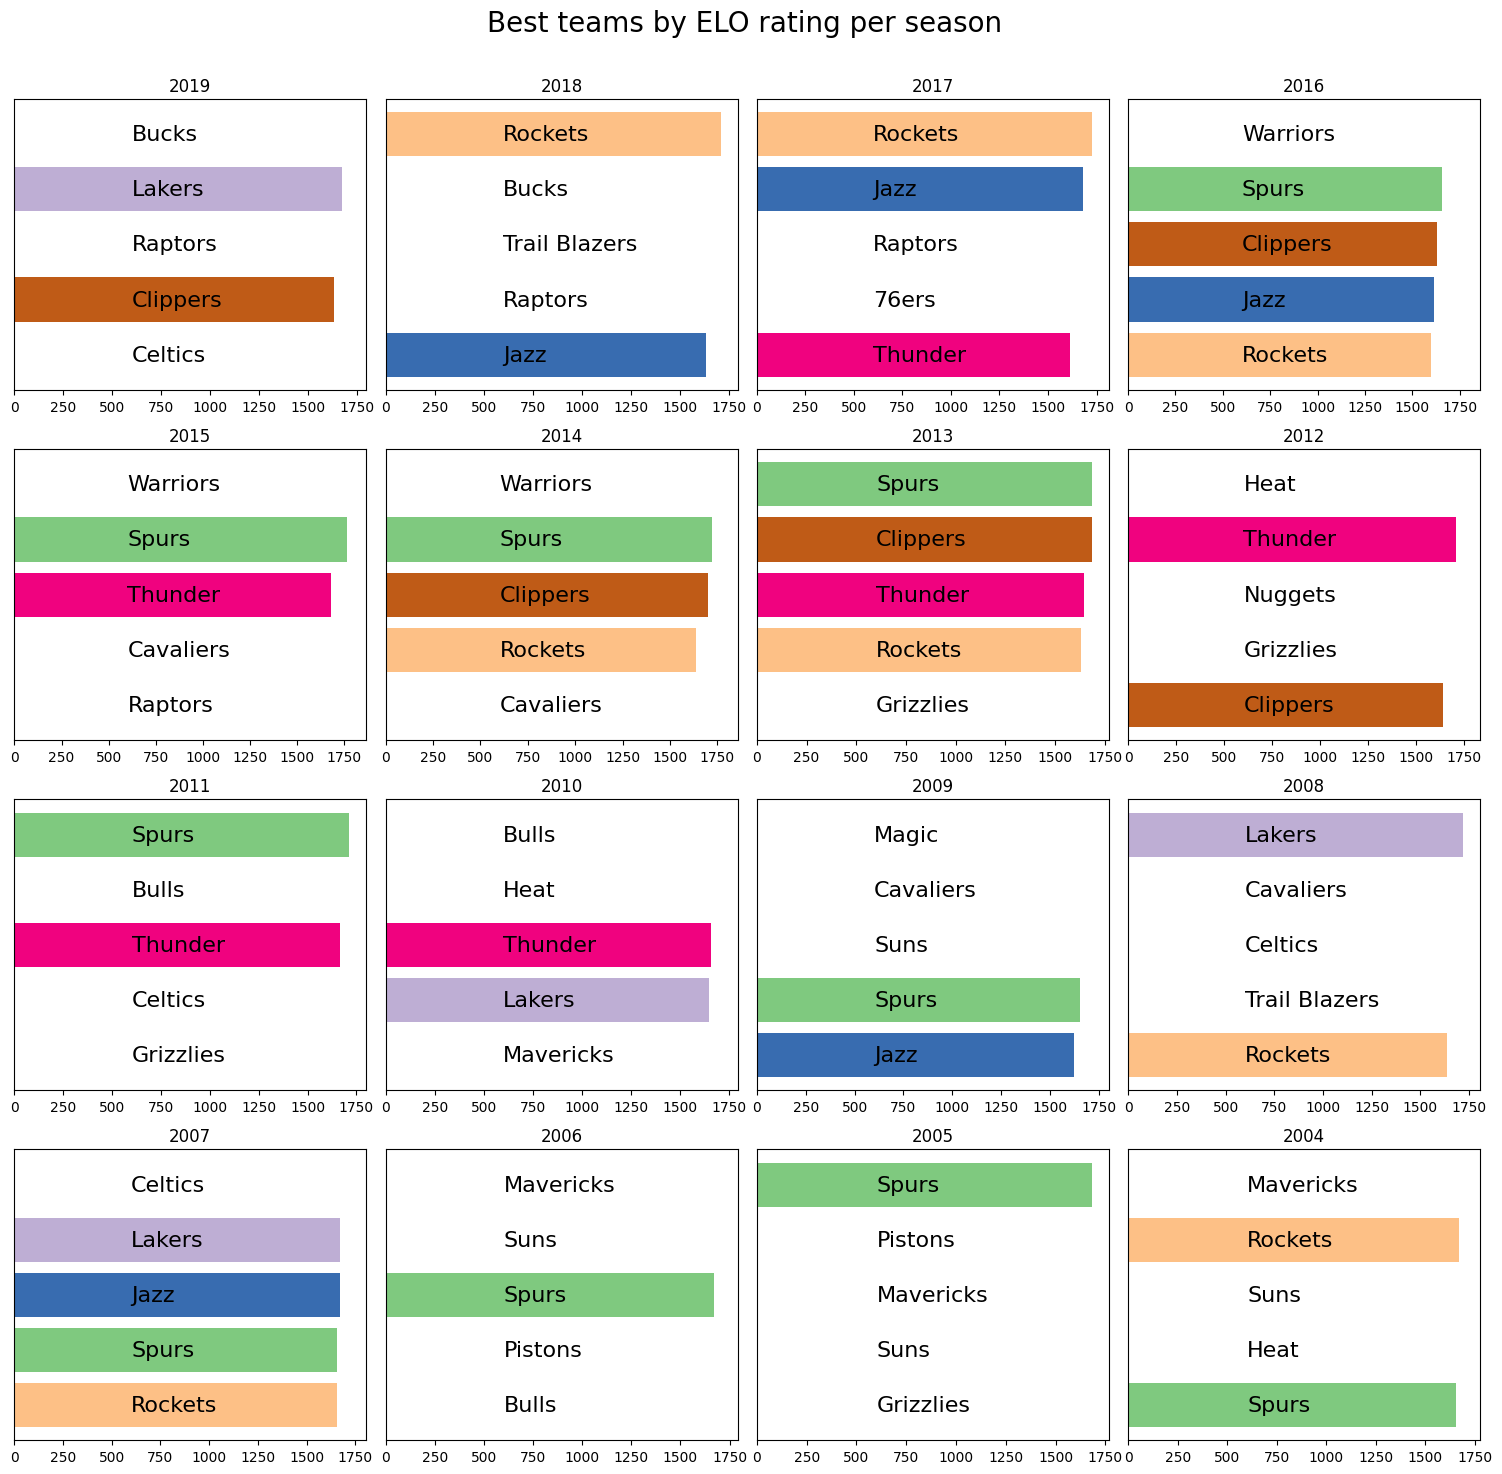

In [52]:
fig,axes = plt.subplots(4, 4, figsize=(15,15))
for i,season in enumerate(range(elo_plot_df.SEASON.max(), elo_plot_df.SEASON.min(), -1)):
    data = elo_plot_df.loc[elo_plot_df.SEASON == season].sort_values(by='ELO')
    axes.ravel()[i].tick_params(left=False, labelleft = False)
    axes.ravel()[i].barh(y=data.NAME, width=data.ELO, color=data.NAME.map(color_dict))
    axes.ravel()[i].set_title(str(season))
    for j,name in enumerate(data.NICKNAME):
        axes.ravel()[i].text(s=name, x=600, y=j, color="black", verticalalignment="center",size=16)
        
fig.suptitle('Best teams by ELO rating per season', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top=0.92)
plt.show()

The ELO rating looks in line with the results of the respective seasons. The most consistent teams in terms of seasons in the top 5 have their own colour. It becomes evident that the Spurs have dominated the last 15 years and are consistently one of the best teams in the league. 


Note that the ELO rating was calculated only based on regular season results and not playoff success. This becomes more important in later seasons as teams do load management and have understood that having their players healthy and rested in the playoffs is more important than a couple of ranking spots in the regular season.


# Step 4 : Calculating the accuracy of the model 
To test the model we created a dataframe sorted by date which contains all the regular seasons's games and the results of them.
Then we created a test area. These are the matches that the model is going to try to predict out of the dataframe and then we are going to compare the model's prediction with the actual result. In this notebook case, the 'test area' is 'all the games of the seasons 2006 to 2017'.
The result of this accuracy test is of 64,91%



In [53]:
# Combining all the data to create the full dataset
input_data = pd.merge_asof(games_short, ranking_short, left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE', 
                     left_by = 'HOME_TEAM_ID', right_by = 'TEAM_ID', allow_exact_matches = False)
input_data = input_data.loc[~input_data.TEAM_ID.isnull()]
input_data = pd.merge_asof(input_data, ranking_short.add_suffix("_VISITOR"), left_on = 'GAME_DATE_EST', right_on = 'STANDINGSDATE_VISITOR', 
                     left_by = 'VISITOR_TEAM_ID', right_by = 'TEAM_ID_VISITOR', allow_exact_matches = False)

input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G > 50), ['G', 'W', 'L', 'HOME_W', 'HOME_L', 'AWAY_W', 'AWAY_L']] = 0
input_data.loc[(input_data.GAME_DATE_EST.dt.month <= 12) & (input_data.GAME_DATE_EST.dt.month > 9) & (input_data.G_VISITOR > 50), ['G_VISITOR', 'W_VISITOR', 'L_VISITOR', 'HOME_W_VISITOR', 'HOME_L_VISITOR', 'AWAY_W_VISITOR', 'AWAY_L_VISITOR']] = 0

# Adding ELO
input_data = input_data.merge(elo_data[['GAME_ID', 'HOME_ELO', 'VISITOR_ELO']])

input_data['HOME_TEAM'] = input_data['HOME_TEAM_ID'].map(teams_dict)
input_data['VISITOR_TEAM'] = input_data['VISITOR_TEAM_ID'].map(teams_dict)

input_data = input_data.drop(columns = ['HOME_TEAM_ID', 'VISITOR_TEAM_ID', 'TEAM_ID', 'TEAM', 'STANDINGSDATE', 'TEAM_VISITOR', 'STANDINGSDATE_VISITOR'])
input_data['ELO_DIFF'] = input_data.HOME_ELO - input_data.VISITOR_ELO



input_data.drop(columns = ['HOME_TEAM', 'VISITOR_TEAM', 'CONFERENCE', 'CONFERENCE_VISITOR', 'GAME_DATE_EST'], inplace=True)

In [54]:
train_data = input_data.loc[(input_data.SEASON < 2018) & (input_data.SEASON > 2005)]
valid_data = input_data.loc[input_data.SEASON == 2018]
test_data = input_data.loc[input_data.SEASON == 2019]
full_train_data = pd.concat([train_data, valid_data], axis = 0)

X, y = train_data.drop(columns = ['HOME_TEAM_WINS']), train_data.HOME_TEAM_WINS
valid_X, valid_y = valid_data.drop(columns = ['HOME_TEAM_WINS']), valid_data.HOME_TEAM_WINS
test_X, test_y = test_data.drop(columns = ['HOME_TEAM_WINS']), test_data.HOME_TEAM_WINS
full_train_X, full_train_y = full_train_data.drop(columns = ['HOME_TEAM_WINS', 'SEASON', 'GAME_ID']), full_train_data.HOME_TEAM_WINS

train_games = X[['SEASON', 'GAME_ID']]
valid_games = valid_X[['SEASON', 'GAME_ID']]
test_games = test_X[['SEASON', 'GAME_ID']]

X.drop(columns = ['SEASON', 'GAME_ID'], inplace=True)
valid_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)
test_X.drop(columns = ['SEASON', 'GAME_ID'], inplace = True)

In [55]:


print('ELO accuracy: ' + str(np.round(accuracy_score(test_X.ELO_DIFF >= 0, test_y)*100,2)) + ' %')


ELO accuracy: 64.91 %


In [56]:

sorted_team = team_elo.sort_values(by="ELO",ascending=False)


print(sorted_team)

          TEAM          ELO NAME
24  1610612749  1709.472051  MIL
26  1610612747  1673.322887  LAL
5   1610612761  1664.666019  TOR
16  1610612746  1631.741795  LAC
2   1610612738  1620.358277  BOS
14  1610612760  1605.065631  OKC
21  1610612742  1579.338032  DAL
4   1610612743  1573.141223  DEN
7   1610612762  1570.282204  UTA
12  1610612745  1559.949541  HOU
19  1610612754  1556.475098  IND
28  1610612755  1555.609403  PHI
15  1610612763  1548.948652  MEM
18  1610612748  1547.689331  MIA
6   1610612740  1537.548050  NOP
3   1610612758  1504.124258  SAC
11  1610612753  1501.183499  ORL
25  1610612759  1495.406899  SAS
20  1610612757  1487.939746  POR
17  1610612751  1474.337987  BKN
13  1610612756  1449.206710  PHX
23  1610612764  1392.092211  WAS
29  1610612766  1391.587067  CHA
0   1610612744  1351.374120  GSW
9   1610612750  1351.282257  MIN
22  1610612737  1340.920602  ATL
8   1610612752  1339.895222  NYK
1   1610612741  1338.247942  CHI
10  1610612765  1337.382680  DET
27  161061

In [57]:
# Lets try to predict the outcome of the Lakers team versus the Utah jazz Roster
c=float(1673.322887) - float(1570.282204)
print(f"The probability that the Lakers will win over the Utah Jazz Roster is of {win_prob(c)}")


The probability that the Lakers will win over the Utah Jazz Roster is of 0.6440875411034073
